In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from sklearn.utils import shuffle
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 1e-6
BATCH_SIZE = 32
NUM_WORKERS = 2
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
PIN_MEMORY = True
LOAD_MODEL = True

In [2]:
DATA_PATH = "kaggle_3m/"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DATA_PATH, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))
print(DEVICE)

cuda


In [3]:
def is_all_zero(index):
    return np.all((np.array(Image.open(imagePath_df["mask-path"][index]).convert("L")).astype(np.float32) == 0))

In [4]:
"""
Data directory for the masks and images
Format is TCGA_<institution-code>_<patient-id>_<slice-number>.tif
Each image is a slice MRI scan of the patient's brain, with a mask showing tumor area if present
"""

imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})
imagePath_df['image-path'] = DATA_PATH + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DATA_PATH + imagePath_df['directory'] + '/' + imagePath_df['masks']

# Create an equal split of healthy and tumorous data images
healthy_df = pd.DataFrame()
tumor_df = pd.DataFrame()

for idx in range(len(imagePath_df)):
    if is_all_zero(idx):
        healthy_df = healthy_df.append(imagePath_df.loc[idx])
    else:
        tumor_df = tumor_df.append(imagePath_df.loc[idx])

train_healthy , test_healthy = train_test_split(healthy_df, test_size=0.2, random_state=42)
train_tumor , test_tumor = train_test_split(tumor_df, test_size=0.2, random_state=42)
train = shuffle(pd.concat([train_tumor, train_healthy]))
test = shuffle(pd.concat([test_tumor, test_healthy]))

In [5]:
# Show image shape
imagePath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[0], imagePath_df['images'].iloc[0])
maskPath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[0], imagePath_df['masks'].iloc[0])
image = cv2.imread(imagePath)
mask = cv2.imread(maskPath)

image.shape, mask.shape

((256, 256, 3), (256, 256, 3))

In [7]:
def plot_image(i):

    imagePath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[i], imagePath_df['images'].iloc[i])
    maskPath = os.path.join(DATA_PATH, imagePath_df['directory'].iloc[i], imagePath_df['masks'].iloc[i])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.4)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

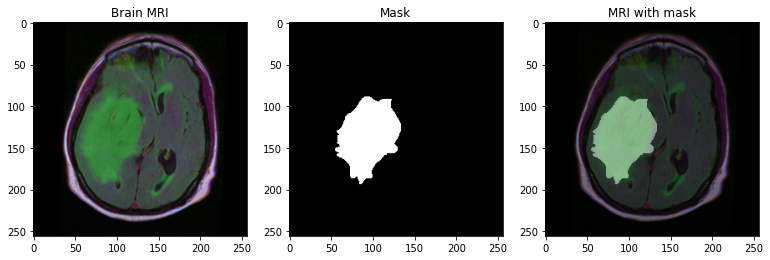

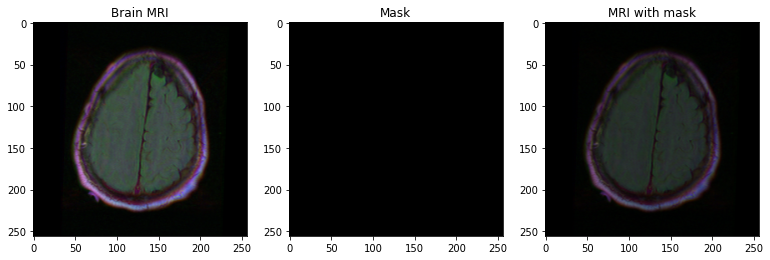

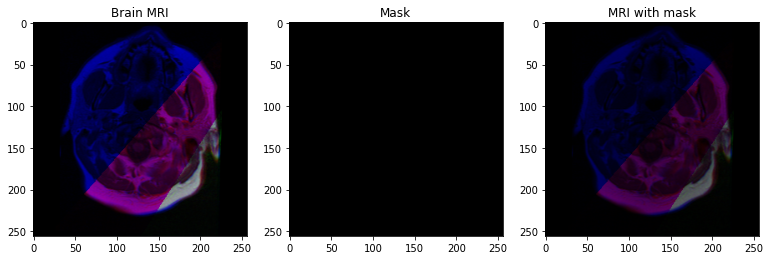

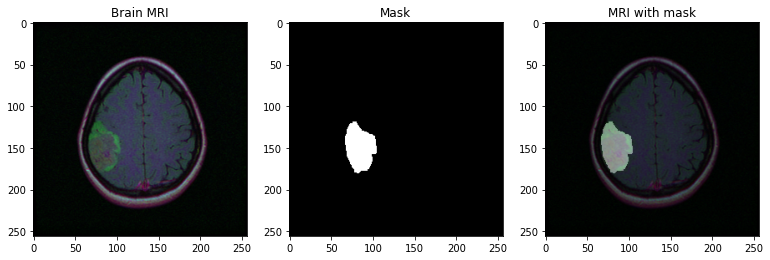

In [8]:
# Plot some example images
sample_images = [5,8,13,24]
for i in sample_images:
    plot_image(i)

In [9]:
# Training samples vs testing samples
len(train), len(test)

(3142, 787)

In [11]:
train

,directory,image-path,images,mask-path,masks
894,TCGA_HT_7693_19950520,kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_1...,TCGA_HT_7693_19950520_19.tif,kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_1...,TCGA_HT_7693_19950520_19_mask.tif
1832,TCGA_DU_6407_19860514,kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_1...,TCGA_DU_6407_19860514_50.tif,kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_1...,TCGA_DU_6407_19860514_50_mask.tif
3147,TCGA_HT_7616_19940813,kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_1...,TCGA_HT_7616_19940813_1.tif,kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_1...,TCGA_HT_7616_19940813_1_mask.tif
2808,TCGA_CS_6667_20011105,kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_2...,TCGA_CS_6667_20011105_4.tif,kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_2...,TCGA_CS_6667_20011105_4_mask.tif
2199,TCGA_HT_7692_19960724,kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_1...,TCGA_HT_7692_19960724_3.tif,kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_1...,TCGA_HT_7692_19960724_3_mask.tif
...,...,...,...,...,...
898,TCGA_HT_7693_19950520,kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_1...,TCGA_HT_7693_19950520_6.tif,kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_1...,TCGA_HT_7693_19950520_6_mask.tif
513,TCGA_DU_7014_19860618,kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_1...,TCGA_DU_7014_19860618_39.tif,kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_1...,TCGA_DU_7014_19860618_39_mask.tif
1892,TCGA_FG_8189_20030516,kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_2...,TCGA_FG_8189_20030516_20.tif,kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_2...,TCGA_FG_8189_20030516_20_mask.tif
2880,TCGA_FG_A4MT_20020212,kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_2...,TCGA_FG_A4MT_20020212_49.tif,kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_2...,TCGA_FG_A4MT_20020212_49_mask.tif


In [13]:
test

,directory,image-path,images,mask-path,masks
329,TCGA_DU_A5TP_19970614,kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_1...,TCGA_DU_A5TP_19970614_7.tif,kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_1...,TCGA_DU_A5TP_19970614_7_mask.tif
977,TCGA_DU_6401_19831001,kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_1...,TCGA_DU_6401_19831001_43.tif,kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_1...,TCGA_DU_6401_19831001_43_mask.tif
3111,TCGA_DU_6400_19830518,kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_1...,TCGA_DU_6400_19830518_18.tif,kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_1...,TCGA_DU_6400_19830518_18_mask.tif
751,TCGA_HT_8018_19970411,kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_1...,TCGA_HT_8018_19970411_20.tif,kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_1...,TCGA_HT_8018_19970411_20_mask.tif
222,TCGA_FG_6688_20020215,kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_2...,TCGA_FG_6688_20020215_14.tif,kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_2...,TCGA_FG_6688_20020215_14_mask.tif
...,...,...,...,...,...
3151,TCGA_HT_7616_19940813,kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_1...,TCGA_HT_7616_19940813_13.tif,kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_1...,TCGA_HT_7616_19940813_13_mask.tif
3884,TCGA_DU_5851_19950428,kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_1...,TCGA_DU_5851_19950428_13.tif,kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_1...,TCGA_DU_5851_19950428_13_mask.tif
3071,TCGA_DU_6400_19830518,kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_1...,TCGA_DU_6400_19830518_17.tif,kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_1...,TCGA_DU_6400_19830518_17_mask.tif
3212,TCGA_CS_6666_20011109,kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_2...,TCGA_CS_6666_20011109_8.tif,kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_2...,TCGA_CS_6666_20011109_8_mask.tif


In [15]:
class BrainMRIDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None):
        self.images = list(image_list)
        self.masks = list(mask_list)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = np.array(Image.open(self.images[index]).convert("RGB"))
        mask = np.array(Image.open(self.masks[index]).convert("L")).astype(np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [16]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [17]:
train_ds = BrainMRIDataset(
    image_list=list(train["image-path"]),
    mask_list=list(train["mask-path"]),
    transform=train_transform,
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_ds = BrainMRIDataset(
    image_list=list(test["image-path"]),
    mask_list=list(test["mask-path"]),
    transform=val_transform,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

Now we move on to defining the neural network, here is a basic network structure:
![UNet](UNet.png)

In [18]:
# First define the double convolution layer for u-net down
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [19]:
class UNET(nn.Module):
    def __init__(
        self, 
        in_channels=3, 
        out_channels=1, 
        features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        # Lowest layer connecting up and down processes
        self.bottom_u = DoubleConv(features[-1], features[-1]*2)
        
        # Final convolution layer to output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottom_u(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [20]:
# Define unet and move to GPU
unet = UNET(in_channels = 3, out_channels = 1)
unet.to(DEVICE)
# Batch size 1, 3 color channels, 256x256 image
test_forward = unet(torch.randn((1, 3, 256, 256)).cuda())
test_forward.shape

torch.Size([1, 1, 256, 256])

In [22]:
# Define checkpoint saving

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [23]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    score = dice_score/len(loader)
    print(f"Dice score: {score}")
    model.train()
    return score

In [24]:
def generate_predictions(
    loader, model, device="cuda"
):
    model.eval()
    predictions = []
    for x, y in loader:
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float().cpu()
            predictions.append((preds, y))
    return predictions

In [25]:
def plot_image(predictions, index):
    
    fig, axs = plt.subplots(1,5, figsize=[13,15])
    
    axs[0].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(predictions[0][1][index])
    axs[1].set_title('Tumor')
    
    axs[2].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[2].imshow(predictions[0][1][index], alpha=0.4)
    axs[2].set_title('Brain with tumor')
    
    axs[4].imshow(predictions[0][0][index].permute(1, 2, 0))
    axs[4].set_title('Predicted tumor')
    
    axs[3].imshow(val_ds[index][0].permute(1, 2, 0))
    axs[3].imshow(predictions[0][0][index].permute(1, 2, 0), alpha=0.4)
    axs[3].set_title('Brain with predicted tumor')
    
    plt.grid(False)
    plt.show()

In [26]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [27]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [28]:
score = 0
accuracy = []
worsen = 0
epochs = 0

# Train until we don't see improvement for 5 consecutive iterations or 100 epochs
while worsen <= 10:
        train_fn(train_loader, unet, optimizer, loss_fn, scaler)

        # check accuracy
        new_score = check_accuracy(val_loader, unet, device=DEVICE)
        accuracy.append(new_score)
        
        if (new_score > score):
            print("better model, saving...")
            worsen = 0
            # save model
            checkpoint = {
                "state_dict": unet.state_dict(),
                "optimizer":optimizer.state_dict(),
            }
            save_checkpoint(checkpoint)
            score = new_score
        else:
            print("over-fitting possibility, skipping...")
            worsen += 1
        epochs += 1

100%|██████████| 99/99 [00:30<00:00,  3.20it/s, loss=0.362]


Got 50722218/51576832 with acc 98.34
Dice score: 0.3750380277633667
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.351]


Got 51261698/51576832 with acc 99.39
Dice score: 0.6357973217964172
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.312]


Got 51274573/51576832 with acc 99.41
Dice score: 0.6642898321151733
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.232]


Got 51299850/51576832 with acc 99.46
Dice score: 0.675086498260498
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.225]


Got 51333579/51576832 with acc 99.53
Dice score: 0.7231248021125793
better model, saving...
=> Saving checkpoint


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51328978/51576832 with acc 99.52
Dice score: 0.6989405155181885
over-fitting possibility, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.36it/s, loss=0.221]


Got 51358783/51576832 with acc 99.58
Dice score: 0.761880099773407
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.209]


Got 51369922/51576832 with acc 99.60
Dice score: 0.7624946236610413
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.201]


Got 51385067/51576832 with acc 99.63
Dice score: 0.8029736876487732
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.38it/s, loss=0.194]


Got 51397661/51576832 with acc 99.65
Dice score: 0.8087247014045715
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.2]  


Got 51399397/51576832 with acc 99.66
Dice score: 0.8119569420814514
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.188]


Got 51415630/51576832 with acc 99.69
Dice score: 0.8407280445098877
better model, saving...
=> Saving checkpoint


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51424111/51576832 with acc 99.70
Dice score: 0.8397135734558105
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51305295/51576832 with acc 99.47
Dice score: 0.6624575853347778
over-fitting possibility, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.175]


Got 51433028/51576832 with acc 99.72
Dice score: 0.8600426316261292
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.173]


Got 51434356/51576832 with acc 99.72
Dice score: 0.8609143495559692
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.169]


Got 51444601/51576832 with acc 99.74
Dice score: 0.8670589923858643
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.42it/s, loss=0.175]


Got 51446461/51576832 with acc 99.75
Dice score: 0.8709433674812317
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.40it/s, loss=0.16] 


Got 51448094/51576832 with acc 99.75
Dice score: 0.8745799660682678
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.43it/s, loss=0.155]


Got 51452376/51576832 with acc 99.76
Dice score: 0.8793256282806396
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.151]


Got 51456825/51576832 with acc 99.77
Dice score: 0.8847719430923462
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.37it/s, loss=0.16] 


Got 51459826/51576832 with acc 99.77
Dice score: 0.8849040269851685
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.144]


Got 51459077/51576832 with acc 99.77
Dice score: 0.8876393437385559
better model, saving...
=> Saving checkpoint


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51449104/51576832 with acc 99.75
Dice score: 0.8755940794944763
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51450433/51576832 with acc 99.75
Dice score: 0.8786758184432983
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51461946/51576832 with acc 99.78
Dice score: 0.8867220282554626
over-fitting possibility, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.135]


Got 51456412/51576832 with acc 99.77
Dice score: 0.8879649639129639
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.13] 


Got 51457857/51576832 with acc 99.77
Dice score: 0.8894036412239075
better model, saving...
=> Saving checkpoint


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51461082/51576832 with acc 99.78
Dice score: 0.8885498046875
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51456719/51576832 with acc 99.77
Dice score: 0.8816080093383789
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51446235/51576832 with acc 99.75
Dice score: 0.8807385563850403
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51456573/51576832 with acc 99.77
Dice score: 0.887669563293457
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51454508/51576832 with acc 99.76
Dice score: 0.8851536512374878
over-fitting possibility, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.115]


Got 51461015/51576832 with acc 99.78
Dice score: 0.8896419405937195
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.39it/s, loss=0.116]


Got 51459561/51576832 with acc 99.77
Dice score: 0.8914456963539124
better model, saving...
=> Saving checkpoint


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.116]


Got 51465017/51576832 with acc 99.78
Dice score: 0.8936727643013
better model, saving...
=> Saving checkpoint


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51463436/51576832 with acc 99.78
Dice score: 0.8921523094177246
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51465374/51576832 with acc 99.78
Dice score: 0.8928293585777283
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51466802/51576832 with acc 99.79
Dice score: 0.8914087414741516
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51457383/51576832 with acc 99.77
Dice score: 0.8899590373039246
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51339396/51576832 with acc 99.54
Dice score: 0.8000385761260986
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51447298/51576832 with acc 99.75
Dice score: 0.8712952136993408
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51461080/51576832 with acc 99.78
Dice score: 0.8894097208976746
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51464978/51576832 with acc 99.78
Dice score: 0.8929767608642578
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51463460/51576832 with acc 99.78
Dice score: 0.8917334675788879
over-fitting possibility, skipping...


  0%|          | 0/99 [00:00<?, ?it/s]

Got 51461800/51576832 with acc 99.78
Dice score: 0.8921677470207214
over-fitting possibility, skipping...


100%|██████████| 99/99 [00:22<00:00,  4.41it/s, loss=0.0868]


Got 51466157/51576832 with acc 99.79
Dice score: 0.8927858471870422
over-fitting possibility, skipping...


In [29]:
# Load best model

load_checkpoint(torch.load("my_checkpoint.pth.tar"), unet)

=> Loading checkpoint


In [30]:
predictions = generate_predictions(val_loader, unet)

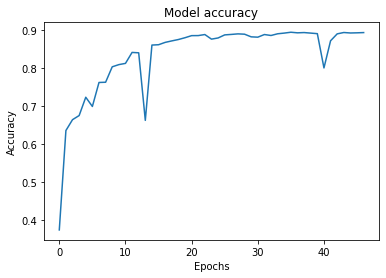

Got 51465017/51576832 with acc 99.78
Dice score: 0.8936727643013


tensor(0.8937, device='cuda:0')

In [31]:
cpu_accuracy = [elem.cpu() for elem in accuracy]
x = np.arange(0, len(accuracy))
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(x, cpu_accuracy)
plt.show()
check_accuracy(val_loader, unet, device=DEVICE)

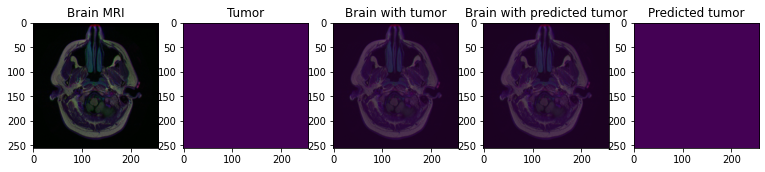

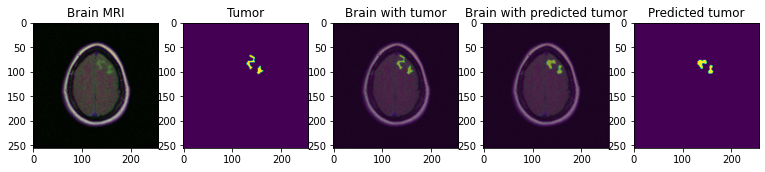

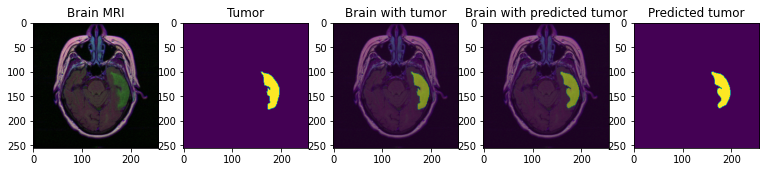

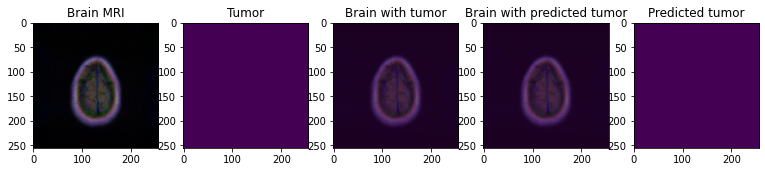

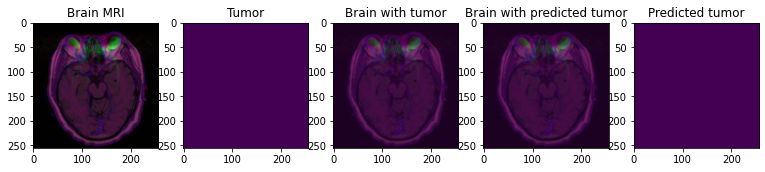

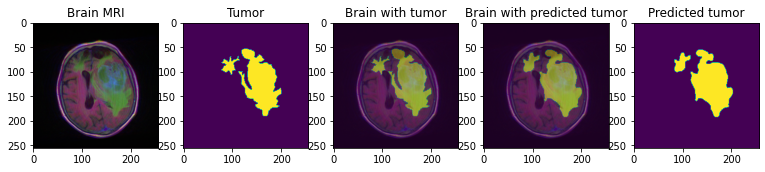

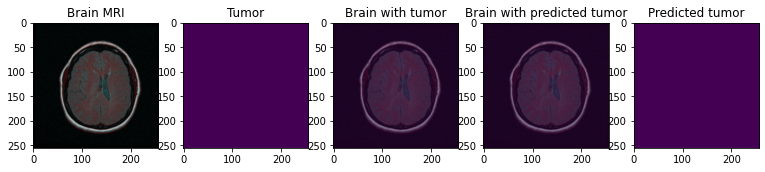

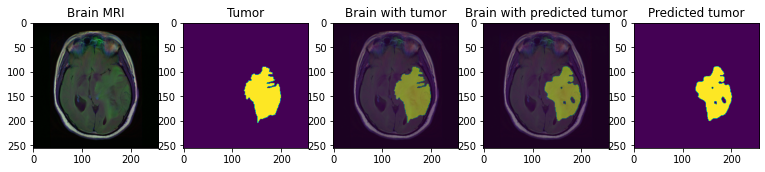

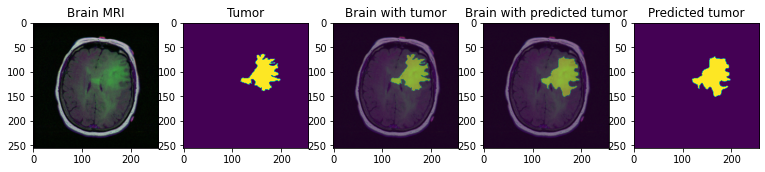

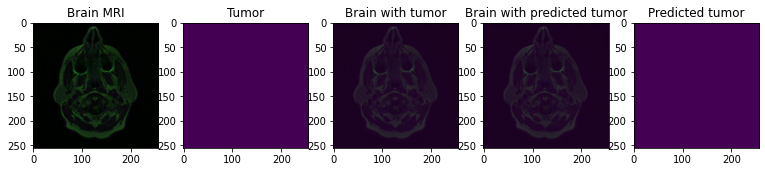

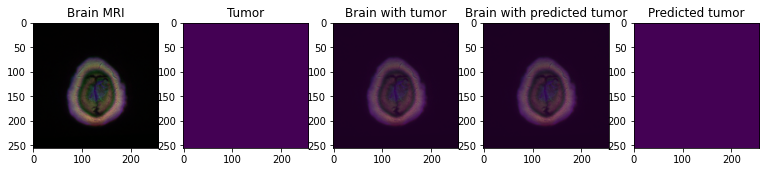

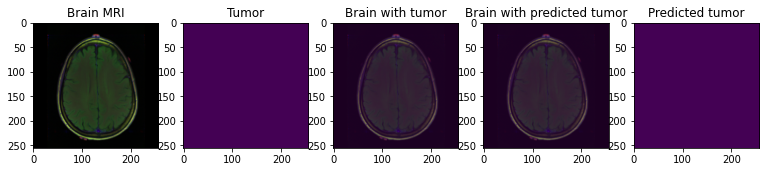

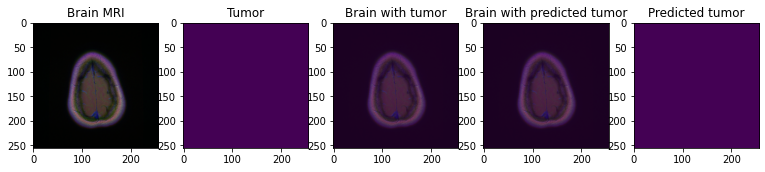

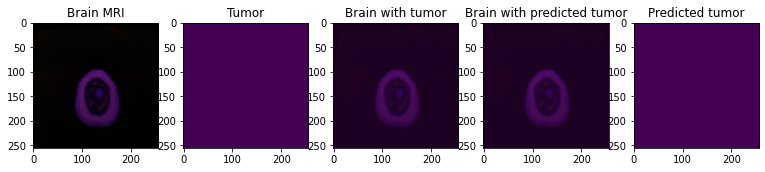

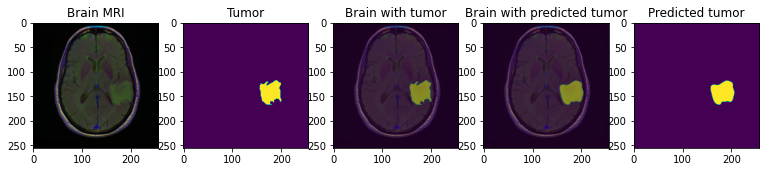

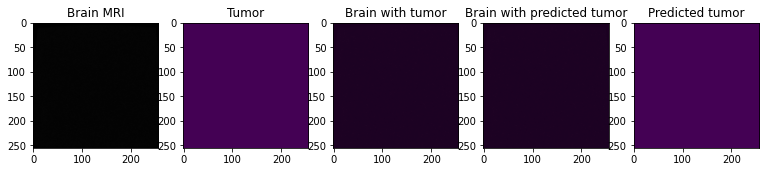

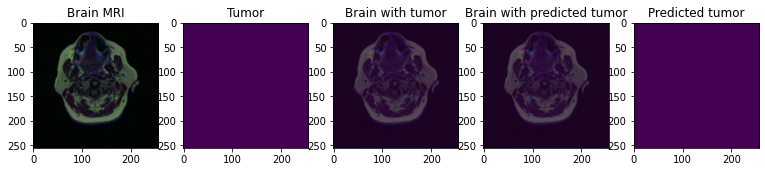

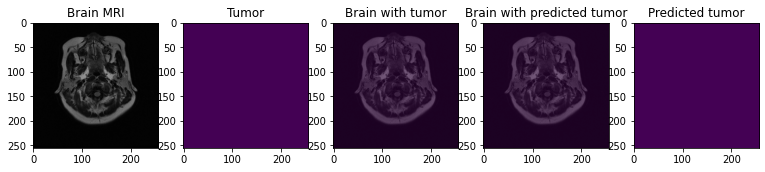

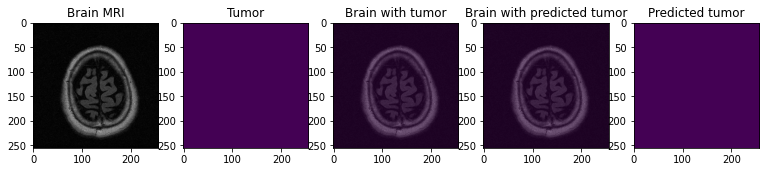

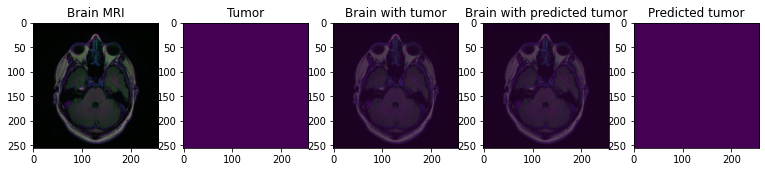

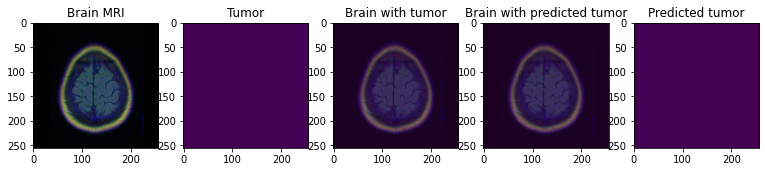

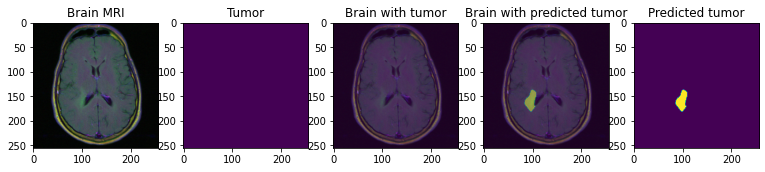

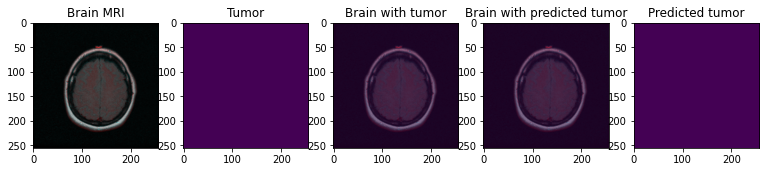

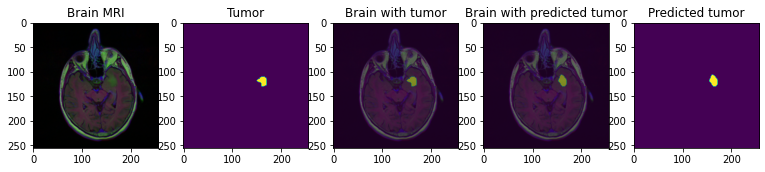

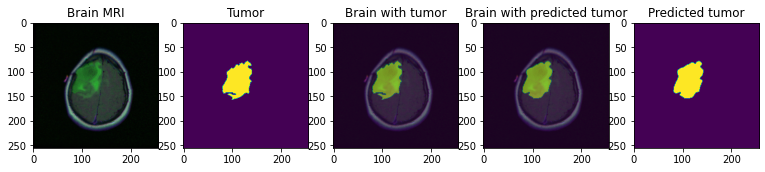

In [33]:
for i in range(len(predictions)):
    plot_image(predictions, i)

In [34]:
check_accuracy(val_loader, unet, device=DEVICE)

Got 51465017/51576832 with acc 99.78
Dice score: 0.8936727643013


tensor(0.8937, device='cuda:0')